In [2]:
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
import time
import mediapipe as mp

In [104]:
dataset_path = '../dataset'

Labels = ['a', 'b', 'c', 'd', 'đ', 'e', 'g', 'h', 'i',
          'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't',
          'u', 'v', 'x', 'y', 'ă', 'â', 'ê', 'ô', 'ơ', 'ư', 'space', 'delete']
sequence_length = 60
num_sequences_per_label = 30


In [105]:
for label in Labels:
    label_path = os.path.join(dataset_path, label)
    if not os.path.exists(label_path):
        os.makedirs(label_path)

In [106]:
# khởi tạo mediapipe hands
mp_hands = mp.solutions.hands

mp_drawing = mp.solutions.drawing_utils
# mp_drawing_styles = mp.solutions.drawing_styles

Nhấn phím bất kỳ để chụp 1 frame...


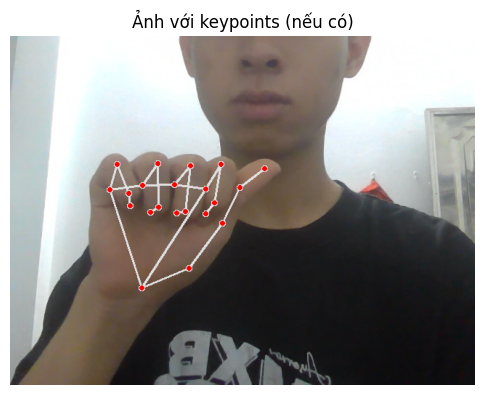

In [131]:
def test_and_plot_one_frame():
    cap = cv2.VideoCapture(0)
    hands = mp_hands.Hands(
        max_num_hands=1,
        min_detection_confidence=0.5,
        min_tracking_confidence=0.5
    )
    print("Nhấn phím bất kỳ để chụp 1 frame...")
    while True:
        ret, frame = cap.read()
        if not ret:
            print("Không lấy được frame từ camera.")
            break
        
        frame = cv2.flip(frame, 1)
        image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        results = hands.process(image_rgb)
        image_bgr = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR)
        
        if results.multi_hand_landmarks:
            hand_landmarks = results.multi_hand_landmarks[0]
            # Vẽ landmarks lên khung hình
            mp_drawing.draw_landmarks(
                image_bgr, hand_landmarks, mp_hands.HAND_CONNECTIONS)
        
        cv2.imshow('Test Camera - Nhấn phím bất kỳ để chụp', image_bgr)
        if cv2.waitKey(1) != -1:
            break

    cap.release()
    cv2.destroyAllWindows()
    hands.close()
    # Plot bằng matplotlib
    plt.figure(figsize=(6,6))
    plt.imshow(cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("Ảnh với keypoints (nếu có)")
    plt.show()

# Gọi hàm test
test_and_plot_one_frame()


In [117]:
label_process = "a"

In [118]:
def collect_label_data(label: str, sequence_num: int):
    global label_process
    cap = cv2.VideoCapture(0)
    hands = mp_hands.Hands(
        max_num_hands=1,
        min_detection_confidence=0.5,
        min_tracking_confidence=0.5
    )
    
    collected_keypoints = []
    frame_count = 0

    print(f"Bắt đầu thu thập {sequence_length} khung hình...")

    # print(f"\n[BẮT ĐẦU] Ghi dữ liệu cho ký '{label}', sequence #{sequence_num}. "
    #       f"Sẽ thu thập {sequence_length} khung hình.")

    while cap.isOpened() and frame_count < sequence_length:
        ret, frame = cap.read()
        if not ret:
            break
        
        # Lật ngang khung để giống gương
        frame = cv2.flip(frame, 1)
        image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Phát hiện keypoints bàn tay
        results = hands.process(image_rgb)
        image_bgr = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR)
        
        if results.multi_hand_landmarks:
            hand_landmarks = results.multi_hand_landmarks[0]
            # Vẽ landmarks lên khung hình
            mp_drawing.draw_landmarks(
                image_bgr, hand_landmarks, mp_hands.HAND_CONNECTIONS)

            # Trích toạ độ 21 điểm (x, y) bình thường hoá [0,1]
            kp_row = []
            for lm in hand_landmarks.landmark:
                kp_row.extend([lm.x, lm.y])
            collected_keypoints.append(kp_row)
            frame_count += 1

        cv2.putText(image_bgr, f'Label: {label} | Frame: {frame_count}/{sequence_length} | Sequence: {sequence_num}/{num_sequences_per_label}',
                    (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 0), 2, cv2.LINE_AA)
        cv2.imshow('Collecting gesture data', image_bgr)

        key = cv2.waitKey(1) & 0xFF
        if key == ord('q'):
            cap.release()
            cv2.destroyAllWindows()
            hands.close()
            label_process = "a"
            return False
        elif key == ord('s'):
            cap.release()
            cv2.destroyAllWindows()
            hands.close()
            label_process = label
            return None

    cap.release()
    cv2.destroyAllWindows()
    hands.close()

    # Nếu đã thu đủ, lưu file .npy
    if len(collected_keypoints) == sequence_length:
        save_path = os.path.join(dataset_path, label, f"{label}_seq{sequence_num}.npy")
        np.save(save_path, np.array(collected_keypoints))
        print(f"[LƯU THÀNH CÔNG] {save_path}")
    else:
        print(f"[THẤT BẠI] Chỉ thu thập được {len(collected_keypoints)} khung hình cho '{label}'. Bỏ qua sequence.")
    return True


In [126]:
try:
    start = False
    for label in Labels:
        if label_process == label:
            start = True
        if not start:
            continue
        for seq_num in range(1, num_sequences_per_label + 1):
            print(f'Collecting data for label: {label}, sequence number: {seq_num}')
            result = collect_label_data(label, seq_num)
            if not result:  # Kiểm tra giá trị trả về
                print("Người dùng đã dừng chương trình")
                raise KeyboardInterrupt 
            elif result is None:  # Người dùng nhấn 's'
                print("Đã lưu tiến trình và dừng chương trình")
                raise KeyboardInterrupt
            time.sleep(1)
    print("Data collection complete.")
except KeyboardInterrupt:
    print("\nChương trình đã dừng theo yêu cầu của người dùng")

Bắt đầu thu thập 60 khung hình...
[LƯU THÀNH CÔNG] ../dataset\ư\ư_seq1.npy
Bắt đầu thu thập 60 khung hình...
[LƯU THÀNH CÔNG] ../dataset\ư\ư_seq2.npy
Bắt đầu thu thập 60 khung hình...
[LƯU THÀNH CÔNG] ../dataset\ư\ư_seq3.npy
Bắt đầu thu thập 60 khung hình...
[LƯU THÀNH CÔNG] ../dataset\ư\ư_seq4.npy
Bắt đầu thu thập 60 khung hình...
[LƯU THÀNH CÔNG] ../dataset\ư\ư_seq5.npy
Bắt đầu thu thập 60 khung hình...
[LƯU THÀNH CÔNG] ../dataset\ư\ư_seq6.npy
Bắt đầu thu thập 60 khung hình...
[LƯU THÀNH CÔNG] ../dataset\ư\ư_seq7.npy
Bắt đầu thu thập 60 khung hình...
[LƯU THÀNH CÔNG] ../dataset\ư\ư_seq8.npy
Bắt đầu thu thập 60 khung hình...
[LƯU THÀNH CÔNG] ../dataset\ư\ư_seq9.npy
Bắt đầu thu thập 60 khung hình...
[LƯU THÀNH CÔNG] ../dataset\ư\ư_seq10.npy
Bắt đầu thu thập 60 khung hình...
[LƯU THÀNH CÔNG] ../dataset\ư\ư_seq11.npy
Bắt đầu thu thập 60 khung hình...
[LƯU THÀNH CÔNG] ../dataset\ư\ư_seq12.npy
Bắt đầu thu thập 60 khung hình...
[LƯU THÀNH CÔNG] ../dataset\ư\ư_seq13.npy
Bắt đầu thu thập 60 k

In [115]:
print(label_process)